In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import EfficientNetV2S

2025-06-13 17:43:09.790591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749836589.813568     637 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749836589.820922     637 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!nvidia-smi

Fri Jun 13 17:43:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
training_data = "/kaggle/input/intel-image-classification/seg_train/seg_train"
classes = os.listdir(training_data)
classes

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [4]:
for dirname, subdir, files in os.walk(training_data):
    print(f"There are {len(subdir)} subdirectories and {len(files)} images in {dirname}")

There are 6 subdirectories and 0 images in /kaggle/input/intel-image-classification/seg_train/seg_train
There are 0 subdirectories and 2512 images in /kaggle/input/intel-image-classification/seg_train/seg_train/mountain
There are 0 subdirectories and 2382 images in /kaggle/input/intel-image-classification/seg_train/seg_train/street
There are 0 subdirectories and 2191 images in /kaggle/input/intel-image-classification/seg_train/seg_train/buildings
There are 0 subdirectories and 2274 images in /kaggle/input/intel-image-classification/seg_train/seg_train/sea
There are 0 subdirectories and 2271 images in /kaggle/input/intel-image-classification/seg_train/seg_train/forest
There are 0 subdirectories and 2404 images in /kaggle/input/intel-image-classification/seg_train/seg_train/glacier


In [5]:
train_data = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_data = "/kaggle/input/intel-image-classification/seg_test/seg_test"

In [6]:
IMAGE_SIZE = 224
EPOCHS = 10

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [9]:
num_classes = len(train_generator.class_indices)
num_classes

6

In [10]:
# paths to save the best trained model
inception_best_model = "/kaggle/working/inception.keras"
efficientnet_best_model = "/kaggle/working/efficientnet.keras"

def get_callbacks(best_model_path, metric='val_Accuracy'):
    
    callbacks = [
        ModelCheckpoint(best_model_path, monitor=metric, mode='max', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor=metric, patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor=metric, patience=5, mode='max', verbose=1, restore_best_weights=True)
    ]
    
    return callbacks

In [11]:
# Pretrained inceptionv3 model without top layer
inceptionv3 = InceptionV3(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

def build_model(base_model, num_classes):

    # Finetuning - only unfreeze last 20 layers 
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add new layers on top of the base model
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    prediction = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=prediction)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['Accuracy'])

    return model

model = build_model(base_model=inceptionv3, num_classes=num_classes)

# train the model 
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    callbacks=get_callbacks(best_model_path=inception_best_model)
                   )

I0000 00:00:1749836603.392420     637 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1749836619.502383     700 service.cc:148] XLA service 0x1b1fdfc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749836619.502422     700 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749836621.427152     700 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/878 ━━━━━━━━━━━━━━━━━━━━ 5:18:32 22s/step - Accuracy: 0.0625 - loss: 2.1774

I0000 00:00:1749836628.044118     700 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - Accuracy: 0.8047 - loss: 0.5504
Epoch 1: val_Accuracy improved from -inf to 0.92300, saving model to /kaggle/working/inception.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 201s 204ms/step - Accuracy: 0.8048 - loss: 0.5502 - val_Accuracy: 0.9230 - val_loss: 0.2171 - learning_rate: 1.0000e-04
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - Accuracy: 0.8948 - loss: 0.2952
Epoch 2: val_Accuracy did not improve from 0.92300
878/878 ━━━━━━━━━━━━━━━━━━━━ 158s 180ms/step - Accuracy: 0.8948 - loss: 0.2952 - val_Accuracy: 0.9220 - val_loss: 0.2037 - learning_rate: 1.0000e-04
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - Accuracy: 0.9150 - loss: 0.2348
Epoch 3: val_Accuracy did not improve from 0.92300
878/878 ━━━━━━━━━━━━━━━━━━━━ 159s 181ms/step - Accuracy: 0.9150 - loss: 0.2348 - val_Accuracy: 0.9227 - val_loss: 0.1962 - learning_rate: 1.0000e-04
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - Accuracy: 0.9147 - loss: 0.2327
Epoch 4: 

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 27,251,764 (103.96 MB)

 Trainable params: 2,461,446 (9.39 MB)

 Non-trainable params: 19,867,424 (75.79 MB)

 Optimizer params: 4,922,894 (18.78 MB)

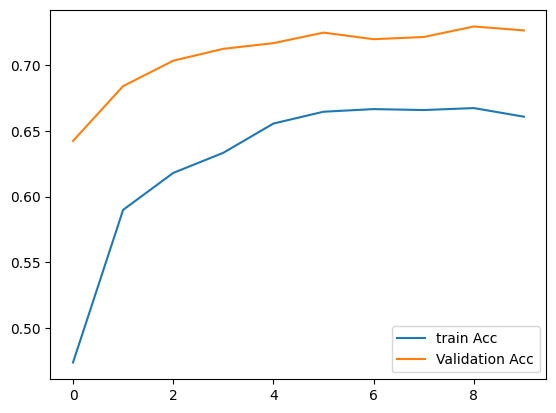

In [17]:
plt.plot(history.history['Accuracy'], label='train Acc')
plt.plot(history.history['val_Accuracy'], label='Validation Acc')
plt.legend()
plt.show()

In [15]:
# Pretrained efficientnetv2s model without top layer
efficientnetv2s = EfficientNetV2S(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

model2 = build_model(base_model=efficientnetv2s, num_classes=num_classes)

# train the model 
history = model2.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    callbacks=get_callbacks(best_model_path=efficientnet_best_model)
                   )

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


E0000 00:00:1749838660.047658     701 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749838660.270698     701 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - Accuracy: 0.3994 - loss: 1.4705
Epoch 1: val_Accuracy improved from -inf to 0.64233, saving model to /kaggle/working/efficientnet.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 257s 225ms/step - Accuracy: 0.3995 - loss: 1.4703 - val_Accuracy: 0.6423 - val_loss: 0.9089 - learning_rate: 1.0000e-04
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - Accuracy: 0.5804 - loss: 1.0887
Epoch 2: val_Accuracy improved from 0.64233 to 0.68400, saving model to /kaggle/working/efficientnet.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 160s 183ms/step - Accuracy: 0.5804 - loss: 1.0887 - val_Accuracy: 0.6840 - val_loss: 0.8152 - learning_rate: 1.0000e-04
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - Accuracy: 0.6178 - loss: 0.9864
Epoch 3: val_Accuracy improved from 0.68400 to 0.70333, saving model to /kaggle/working/efficientnet.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 160s 183ms/step - Accuracy: 0.6178 - loss: 0.9864 - val_Accuracy: 0.7033 - val_loss: 0.7724 - learning

In [16]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 23,990,516 (91.52 MB)

 Trainable params: 1,664,838 (6.35 MB)

 Non-trainable params: 18,996,000 (72.46 MB)

 Optimizer params: 3,329,678 (12.70 MB)